In [ ]:
%load_ext autoreload
%autoreload 2

### Imports

In [1]:
import tensorflow as tf
from psychrnn.backend.models.basic import Basic
from psychrnn.backend.gain.basic2 import Basic2
from psychrnn.backend.gain.loss import rt_mask_mse_06, rt_mask_mse_07, rt_mask_mse_08
from psychrnn.tasks.checker import Checkerboard2AFC

from tqdm import tqdm
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

import os

### Initialize Task

In [2]:
experiment = 'interactive'
name = 'basic'

In [3]:
dt = 10
tau = 50
T = 5000
N_batch = 50
N_rec = 100

In [4]:
task = Checkerboard2AFC(dt=dt, tau=tau, T=T, N_batch=N_batch)

### Set up parameters

In [5]:
network_params = task.get_task_params()
network_params['name'] = name
network_params['N_rec'] = N_rec
network_params['rec_noise'] = 0.5

network_params["transfer_function"] = tf.nn.relu
network_params["output_transfer_function"] = tf.nn.sigmoid

network_params["loss_function"] = "rt_mask_mse"
network_params["rt_mask_mse"] = rt_mask_mse_07


In [6]:
try:
    model.destruct()
except:
    pass

model = Basic2(network_params)

### Train Model

In [7]:
trials = 50000
train_params = {}
# train_params['save_weights_path'] =  "./weihts/basic2_w"
train_params['training_iters'] = trials
train_params['learning_rate'] = .001
train_params['loss_epoch'] = 10
train_params['save_training_weights_epoch'] = 1000 / N_batch
train_params['training_weights_path'] = None

In [8]:
losses, initialTime, trainTime = model.train(task, train_params)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Iter 500, Minibatch Loss= 0.060556
Iter 1000, Minibatch Loss= 0.146148
Iter 1500, Minibatch Loss= 0.122563
Iter 2000, Minibatch Loss= 0.101963
Iter 2500, Minibatch Loss= 0.052627
Iter 3000, Minibatch Loss= 0.053999
Iter 3500, Minibatch Loss= 0.039653
Iter 4000, Minibatch Loss= 0.027739
Iter 4500, Minibatch Loss= 0.031022
Iter 5000, Minibatch Loss= 0.030056
Iter 5500, Minibatch Loss= 0.032687
Iter 6000, Minibatch Loss= 0.036746
Iter 6500, Minibatch Loss= 0.028023
Iter 7000, Minibatch Loss= 0.032662
Iter 7500, Minibatch Loss= 0.019241
Iter 8000, Minibatch Loss= 0.033136
Iter 8500, Minibatch Loss= 0.024004
Iter 9000, Minibatch Loss= 0.016417
Iter 9500, Minibatch Loss= 0.017153
Iter 10000, Minibatch Loss= 0.014735
Iter 10500, Minibatch Loss= 0.020937
Iter 11000, Minibatch Loss= 0.020054
Iter 11500, Minibatch Loss= 0.029185
Iter 12000, Minibatch Loss= 0.024198
Iter 12500, Minibatch Loss= 0.019223
I

Text(0.5, 1.0, 'Loss During Training')

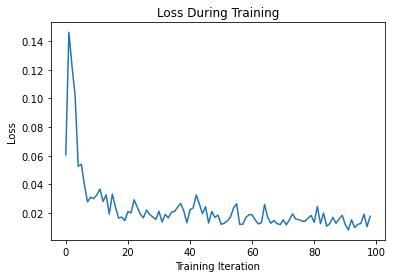

In [9]:
plt.plot(losses)
plt.ylabel("Loss")
plt.xlabel("Training Iteration")
plt.title("Loss During Training")

### Test on 5000 trials to examine performance

In [10]:
trials = 5000
batches = int(np.ceil(trials / N_batch))

rnn_state = np.zeros((trials, task.N_steps, model.N_rec))
rnn_out = np.zeros((trials, task.N_steps, model.N_out))

coherence = np.zeros(trials)
green_side = np.zeros(trials)
target_onset = np.zeros(trials)
checker_onset = np.zeros(trials)

decision = np.zeros(trials)
rt = np.zeros(trials)

In [11]:
for b in tqdm(range(batches)):
    x, y, m, params = task.get_trial_batch()
    outputs, states, inputs = model.test(x)
    
    start_index = N_batch * b
    end_index = N_batch * (b + 1)
    rnn_state[start_index:end_index] = states
    rnn_out[start_index:end_index] = outputs
    
    thr = np.where(outputs > 0.7)
    
    for i in range(N_batch):
        index = start_index + i
        
        coherence[index] = params[i]["coherence"]
        green_side[index] = params[i]["side"]
        target_onset[index] = params[i]["target_onset"]
        checker_onset[index] = params[i]["checker_onset"]
        
        thr_time = thr[1][thr[0]==i][0] if sum(thr[0]==i) > 0 else outputs.shape[1]
        thr_unit = thr[2][thr[0]==i][0] if sum(thr[0]==i) > 0 else np.argmax(outputs[i, -1])
        decision[index] = thr_unit
        rt[index] = thr_time*task.dt - target_onset[index] - checker_onset[index]       

100%|██████████| 100/100 [00:53<00:00,  1.88it/s]


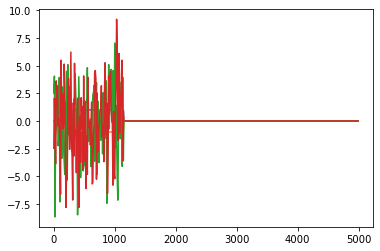

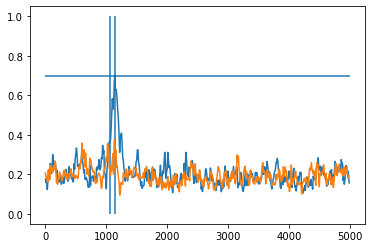

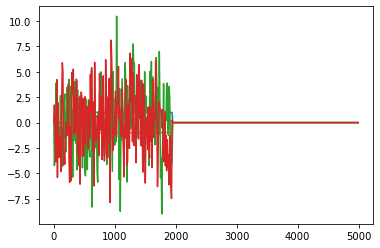

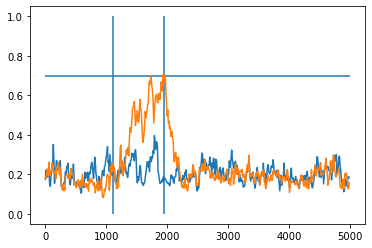

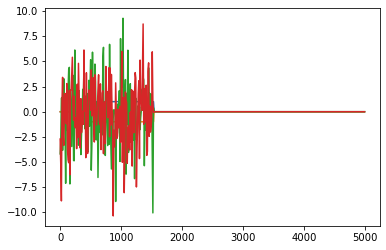

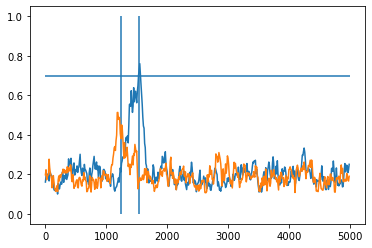

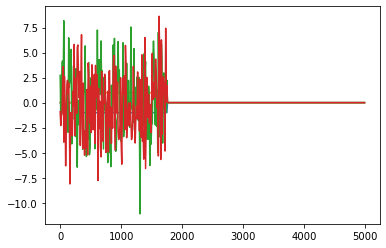

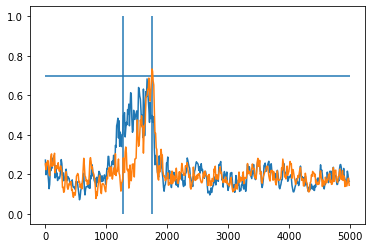

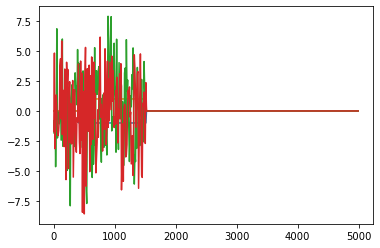

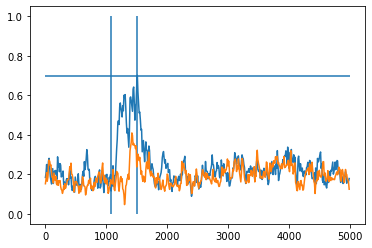

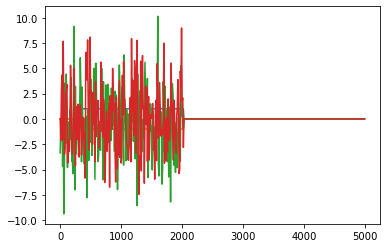

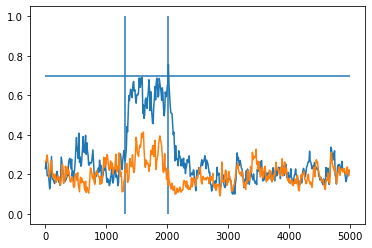

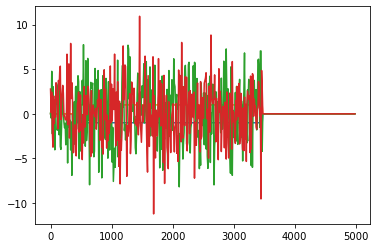

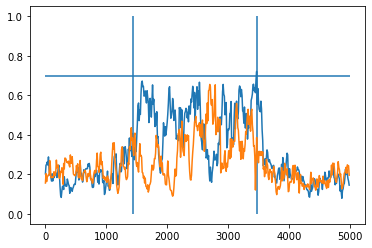

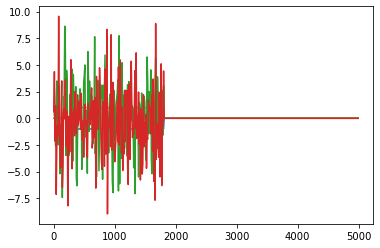

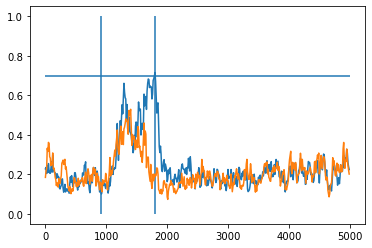

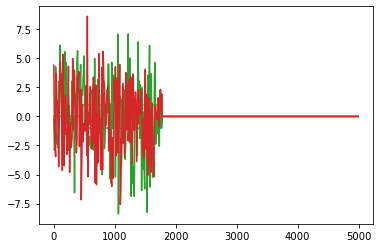

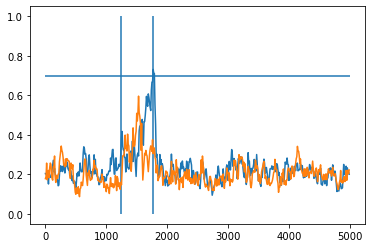

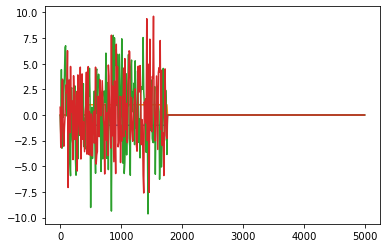

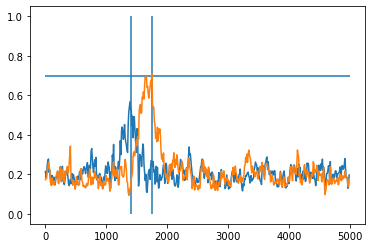

In [13]:
#onsets = [p["onset_time"] for p in params]
onsets = target_onset[-N_batch:] + checker_onset[-N_batch:]
rts = rt[-N_batch:]
for i in range(10):
    plt.figure()
    plt.plot(np.arange(0, T, 10), inputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 1])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 2])
    plt.plot(np.arange(0, T, 10), inputs[i, :, 3])

    plt.figure()
    plt.plot(np.arange(0, T, 10), outputs[i, :, 0])
    plt.plot(np.arange(0, T, 10), outputs[i, :, 1])
    
    plt.vlines(onsets[i], 0, 1)
    plt.vlines(onsets[i] + rts[i], 0, 1)
    plt.hlines(0.7, 0, T)

In [14]:
correct_side = np.array([gs if coh > 0 else abs(gs-1) for coh, gs in zip(coherence, green_side)])
green_decision = np.array([int(dec == gs) for dec, gs in zip(decision, green_side)])
checker_df = pd.DataFrame({'trial' : np.arange(trials),
                           'coherence' : coherence,
                           'coherence_bin' : np.round(coherence, 1),
                           'green_side' : green_side,
                           'correct_side' : correct_side,
                           'target_onset' : target_onset,
                           'checker_onset' : checker_onset,
                           'decision' : decision,
                           'green_decision' : green_decision,
                           'decision_time' : rt,
                           'correct_decision' : (decision == correct_side).astype(int)})
checker_mean = checker_df.groupby('coherence_bin').mean().reset_index()


In [15]:
checker_mean

,coherence_bin,trial,coherence,green_side,correct_side,target_onset,checker_onset,decision,green_decision,decision_time,correct_decision
0,-0.9,2376.376000,-0.874417,0.472000,0.528000,365.624000,751.600000,0.504000,0.024000,351.496000,0.976000
1,-0.8,2513.777344,-0.798553,0.480469,0.519531,375.132812,738.894531,0.503906,0.023438,390.933594,0.976562
2,-0.7,2459.882562,-0.700684,0.473310,0.526690,380.341637,747.925267,0.516014,0.017794,421.982206,0.982206
3,-0.6,2512.040678,-0.598843,0.522034,0.477966,365.091525,748.535593,0.461017,0.044068,442.745763,0.955932
4,-0.5,2522.895307,-0.501782,0.490975,0.509025,371.830325,759.877256,0.462094,0.054152,479.953069,0.945848
5,-0.4,2586.751678,-0.398657,0.469799,0.530201,378.000000,744.251678,0.473154,0.110738,558.151007,0.889262
6,-0.3,2488.396296,-0.297075,0.500000,0.500000,374.522222,740.588889,0.440741,0.133333,615.592593,0.866667
7,-0.2,2281.549815,-0.202766,0.505535,0.494465,373.099631,746.273063,0.435424,0.228782,654.132841,0.771218
8,-0.1,2574.311688,-0.099095,0.555195,0.444805,377.055195,745.175325,0.383117,0.314935,669.230519,0.685065
9,0.0,2349.251908,-0.000331,0.465649,0.541985,369.603053,746.645038,0.393130,0.454198,695.774809,0.530534


# Check whether negative RT

0.0178


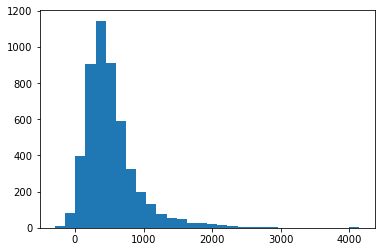

In [53]:
_ = plt.hist(checker_df["decision_time"], bins = 30)
print(np.sum(checker_df["decision_time"] < 0)/5000)

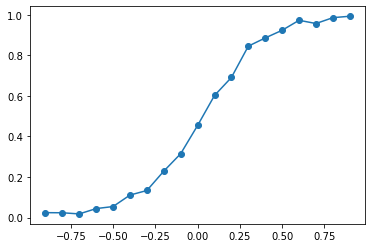

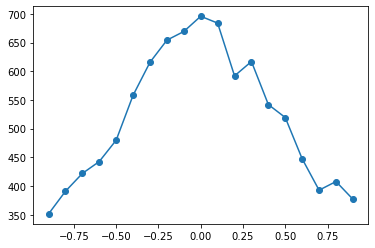

In [16]:
plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['green_decision'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['green_decision'])

plt.figure()
plt.plot(checker_mean['coherence_bin'], checker_mean['decision_time'])
plt.scatter(checker_mean['coherence_bin'], checker_mean['decision_time'])

# RT within same coherence

In [ ]:
for i in [0.9,0.7,0.5,0.3,0.1,0]:
    a = checker_df['coherence_bin'] == i
    groupCo = checker_df.loc[a,:]
    RT = groupCo["decision_time"]
    plt.figure()
    plt.hist(RT)
    plt.title("Coherence: " + str(i))

# Extract firing rate of each unit

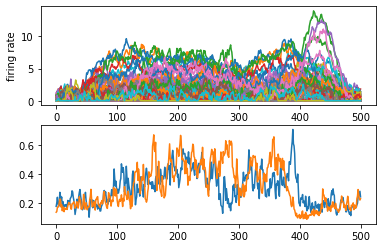

In [43]:
plt.figure()
plt.subplot(211)
_ = plt.plot(rnn_state[0,:,:])
plt.xlabel("time step (10ms)")
plt.ylabel("firing rate")
plt.subplot(212)
_ = plt.plot(rnn_out[0,:,:])

## save the firing rate of of each unit and output
# trialDat = {'x':rnn_state, 'y':rnn_out}
# np.save("trialDat.npy",trialDat)
# TrialData = np.load("trialDat.npy",allow_pickle='TRUE').item()

(5000, 500, 2)

In [ ]:
model.destruct()